In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import SequentialSampler
import skimage
from multiprocessing import Pool
from progressbar import progressbar as pb
import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib.backends.backend_pdf import PdfPages

torch.cuda.get_device_name(0)

'Tesla M60'

In [2]:
%%javascript
$('.nbp-app-bar').toggle()

<IPython.core.display.Javascript object>

In [3]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [4]:
train_inds = list(np.random.choice(np.arange(50000), 20000))
test_inds = list(np.random.choice(np.arange(10000), 4000))

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=preprocess)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=24, 
                                          num_workers=0, sampler=SequentialSampler(train_inds))

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=preprocess)
testloader = torch.utils.data.DataLoader(testset, batch_size=24,
                                         num_workers=0, sampler=SequentialSampler(test_inds))

Files already downloaded and verified
Files already downloaded and verified


In [6]:
def noisify(batch):
    n_mu, n_sigma, r_mu, r_sigma = 0.5, 1.25, 0.1, 0.1
    mu_t = torch.empty(1).uniform_(-n_mu, n_mu).item()
    sigma_t = torch.empty(1).uniform_(1, n_sigma).item()

    m_t = torch.empty((batch.shape)).uniform_(mu_t - r_mu, mu_t + r_mu).type(torch.cuda.FloatTensor)
    s_t = torch.empty((batch.shape)).normal_(sigma_t, r_sigma).type(torch.cuda.FloatTensor)
    
    return (torch.mul(s_t, batch) + m_t)

In [7]:
class VGG2(nn.Module):
    def __init__(self, batchnorm=False, noise=False):
        super(VGG2, self).__init__()
        self.batchnorm = batchnorm
        self.noise = noise
        
        self.pool = nn.MaxPool2d(2, 2)

        self.conv1_1 = nn.Conv2d(3, 64, 3, 1)

        self.conv2_1 = nn.Conv2d(64, 128, 3, 1)

        self.conv3_1 = nn.Conv2d(128, 256, 3, 1)
        self.conv3_2 = nn.Conv2d(256, 256, 3, 1)

        self.conv4_1 = nn.Conv2d(256, 512, 3, 1)
        self.conv4_2 = nn.Conv2d(512, 512, 3, 1)

        self.conv5_1 = nn.Conv2d(512, 512, 3, 1)
        self.conv5_2 = nn.Conv2d(512, 512, 3, 1)

        self.fc1 = nn.Linear(4608, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.out = nn.Linear(4096, 10)

        if self.batchnorm:
            self.bn1 = nn.BatchNorm2d(64)
            self.bn2 = nn.BatchNorm2d(128)
            self.bn3 = nn.BatchNorm2d(256)
            self.bn4 = nn.BatchNorm2d(512)
            self.bn5 = nn.BatchNorm1d(4096)
            
    def forward(self, x):
        if not self.batchnorm:
            x = F.relu(self.conv1_1(x))
            x = self.pool(x)

            x = F.relu(self.conv2_1(x))
            x = self.pool(x)

            x = F.relu(self.conv3_1(x))
            x = F.relu(self.conv3_2(x))
            x = self.pool(x)

            x = F.relu(self.conv4_1(x))
            x = F.relu(self.conv4_2(x))
            x = self.pool(x)

            x = F.relu(self.conv5_1(x))
            x = F.relu(self.conv5_2(x))
            x = self.pool(x)
            x = x.view(x.shape[0], -1)

            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.out(x)
            
        elif self.batchnorm == True and self.noise == False:
            x = F.relu(self.bn1(self.conv1_1(x)))
            x = self.pool(x)

            x = F.relu(self.bn2(self.conv2_1(x)))
            x = self.pool(x)

            x = F.relu(self.bn3(self.conv3_1(x)))
            x = F.relu(self.bn3(self.conv3_2(x)))
            x = self.pool(x)

            x = F.relu(self.bn4(self.conv4_1(x)))
            x = F.relu(self.bn4(self.conv4_2(x)))
            x = self.pool(x)

            x = F.relu(self.bn4(self.conv5_1(x)))
            x = F.relu(self.bn4(self.conv5_2(x)))
            x = self.pool(x)
            x = x.view(x.shape[0], -1)

            x = F.relu(self.bn5(self.fc1(x)))
            x = F.relu(self.bn5(self.fc2(x)))
            x = self.out(x)
            
        elif self.batchnorm == True and self.noise == True:
            x = self.bn1(self.conv1_1(x))
            x = noisify(x)
            x = F.relu(x)
            x = self.pool(x)
            
            x = self.bn2(self.conv2_1(x))
            #x = noisify(x)
            x = F.relu(x)
            x = self.pool(x)

            x = self.bn3(self.conv3_1(x))
            x = noisify(x)
            x = F.relu(x)
            x = self.bn3(self.conv3_2(x))
            #x = noisify(x)
            x = F.relu(x)
            x = self.pool(x)
            
            x = self.bn4(self.conv4_1(x))
            x = noisify(x)
            x = F.relu(x)
            x = self.bn4(self.conv4_2(x))
            #x = noisify(x)
            x = F.relu(x)
            x = self.pool(x)
            
            x = self.bn4(self.conv5_1(x))
            x = noisify(x)
            x = F.relu(x)
            x = self.bn4(self.conv5_2(x))
            #x = noisify(x)
            x = F.relu(x)
            x = self.pool(x)
            x = x.view(x.shape[0], -1)
            
            x = self.bn5(self.fc1(x))
            x = noisify(x)
            x = F.relu(x)
            x = self.bn5(self.fc2(x))
            x = noisify(x)
            x = F.relu(x)
            x = self.out(x)
        
        return x

In [8]:
def train(model, train_loader, optimizer):
    train_acc = []
    model.train()
    for i, batch in enumerate(pb(train_loader)):
        X_batch, y_batch = batch
        X_batch = X_batch.type(torch.cuda.FloatTensor)
        y_batch = y_batch.type(torch.cuda.LongTensor)

        optimizer.zero_grad()

        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        
        max_ind = y_pred.max(1, keepdim=True)[1]
        target_matches = torch.eq(max_ind, y_batch.data.view(len(y_batch), 1))
        accuracy = torch.sum(target_matches).cpu().numpy() / len(y_batch)
        
        train_acc.append(accuracy)
        
        loss.backward()
        optimizer.step()
        
    return np.mean(train_acc) * 100

In [9]:
def validate(model, val_loader):
    model.eval()
    val_acc = []
    for i, batch in enumerate(pb(val_loader)):
        X_batch, y_batch = batch
        X_batch = X_batch.type(torch.cuda.FloatTensor)
        y_batch = y_batch.type(torch.cuda.LongTensor)
        
        y_pred = model(X_batch)
        
        loss = loss_fn(y_pred, y_batch)
        
        max_ind = y_pred.max(1, keepdim=True)[1]
        target_matches = torch.eq(max_ind, y_batch.data.view(len(y_batch), 1))
        accuracy = torch.sum(target_matches).cpu().numpy() / len(y_batch)

        val_acc.append(accuracy)        

    
    return np.mean(val_acc) * 100

Epoch: 10, BN=True, Noise=True
Train accuracy: 65.72242206235012


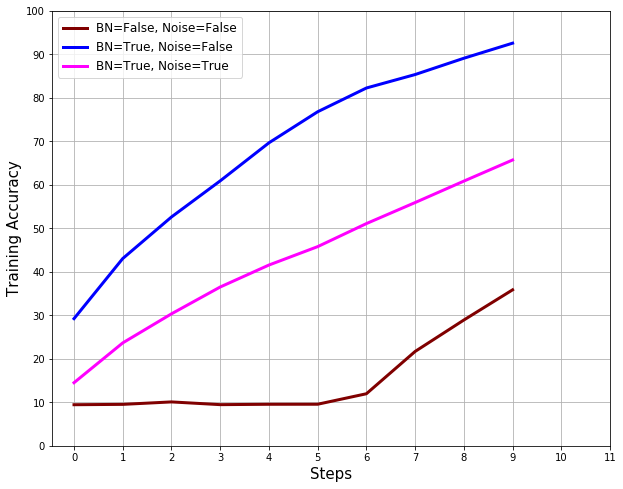

100% (10 of 10) |########################| Elapsed Time: 4:43:10 Time:  4:43:10


In [10]:
train_h = {(False, False): [], (True, False): [], (True, True): []}

batch_flag, noise_flag = [False, True], [False, True]

for flag in batch_flag:
    for noise in noise_flag:
        if not flag and noise:
            continue

        net = VGG2(flag, noise)
        net.cuda()
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

        for epoch in pb(range(10)):
            cur_train = train(net, trainloader, optimizer)
            train_h[(flag, noise)].append(cur_train)
            clear_output()
            print('Epoch: {}, BN={}, Noise={}'.format(epoch+1, flag, noise))
            print("Train accuracy: {}".format(cur_train))

            f = plt.figure(figsize=(10,8))

            plt.plot(train_h[(False, False)], color='maroon', linewidth=3, \
                     label='BN={}, Noise={}'.format(False, False))
            plt.plot(train_h[(True, False)], color='blue', linewidth=3, \
                     label='BN={}, Noise={}'.format(True, False))
            plt.plot(train_h[(True, True)], color='magenta', linewidth=3, \
                     label='BN={}, Noise={}'.format(True, True))
            plt.grid()
            plt.legend(fontsize=12)
            plt.ylabel('Training Accuracy', size=15)
            plt.xlabel('Steps', size=15)
            plt.yticks(np.arange(0,101,10), np.arange(0,101,10))
            plt.xticks(np.arange(0,12),np.arange(0,12))

            pp = PdfPages('first.pdf')
            pp.savefig(f)
            pp.close()
            f.savefig('first.png')
            plt.show()